In [340]:
import glob
import os
import pandas as pd
import seaborn as snsß
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
import seaborn as sns
import pandas as pd
from algos.alg_fpd import Fpd
from algos.alg_fpd_extended import FpdExtended
from algos.alg_fpd_predictor import FpdPredictor
import numpy as np
from bitarray import bitarray, util, bits2bytes
import tqdm
import struct
from shapely.geometry import shape
from collections import defaultdict
import math
import random
from algos.fpd_extended_lib.compress import *


100%|██████████| 10259/10259 [00:06<00:00, 1471.96it/s]


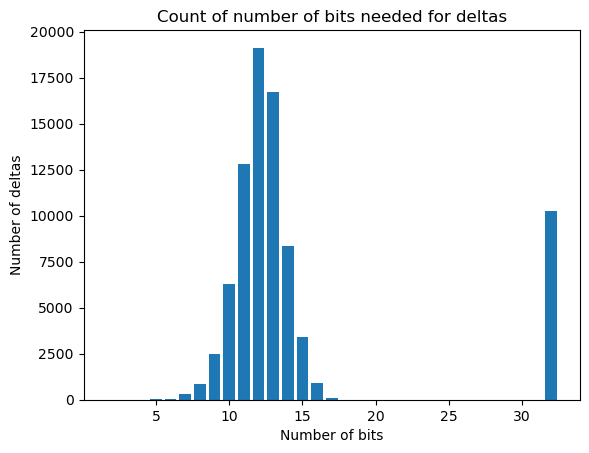

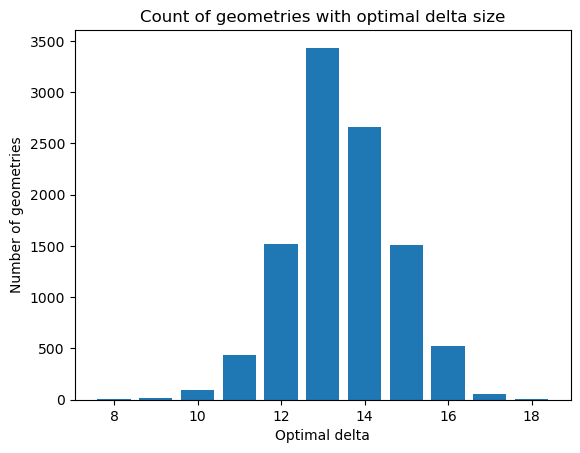

In [341]:
fpd = FpdExtended()

import bench_utils
df, unary_idxs = bench_utils.read_dataset("data/lund_building_highway.json")
unary_idxs = list(set(unary_idxs))
bins = []

tot_bit_count = defaultdict(int)
opt_size_distribution = defaultdict(int)
deltas_fp = []
deltas_long = []
# Compress files, benchmark unaries
for idx in tqdm.tqdm(unary_idxs): # List of single idxs
    opt_size, bit_count, deltas = calculate_delta_size(shape(df.iloc[idx]), True)
    deltas_fp += deltas[0]
    deltas_long += deltas[1]
    for bit_count_key in bit_count:
        tot_bit_count[bit_count_key] += bit_count[bit_count_key]
    opt_size_distribution[opt_size] += 1
    bins.append(fpd.compress(shape(df.iloc[idx]))[1])
plt.bar(tot_bit_count.keys(), tot_bit_count.values());
plt.title("Count of number of bits needed for deltas")
plt.xlabel("Number of bits")
plt.ylabel("Number of deltas")
plt.show()

plt.bar(opt_size_distribution.keys(), opt_size_distribution.values());
plt.title("Count of geometries with optimal delta size")
plt.xlabel("Optimal delta")
plt.ylabel("Number of geometries")
plt.show()
deltas_fp = np.array(deltas_fp)

Percentage of total FP deltas within filtered 0.7848072590125392
Percentage of total FP deltas (but removed excessive values) within filtered 0.8975631958546321
Percentage of total LONG + ZZ deltas within filtered 0.8513788205329154
Percentage of total LONG + ZZ deltas (but removed excessive values) within filtered 0.8513788205329154


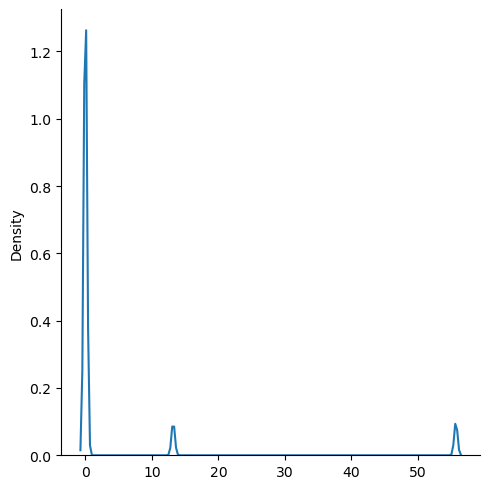

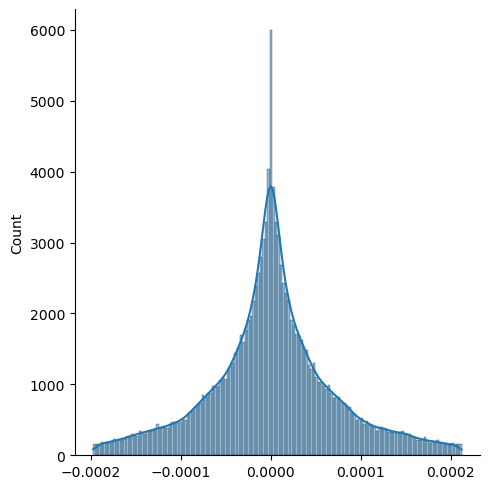

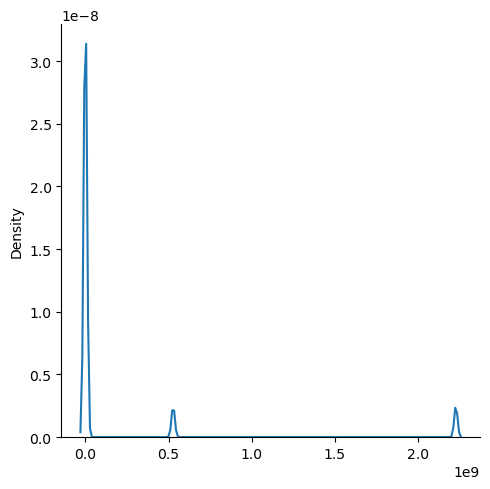

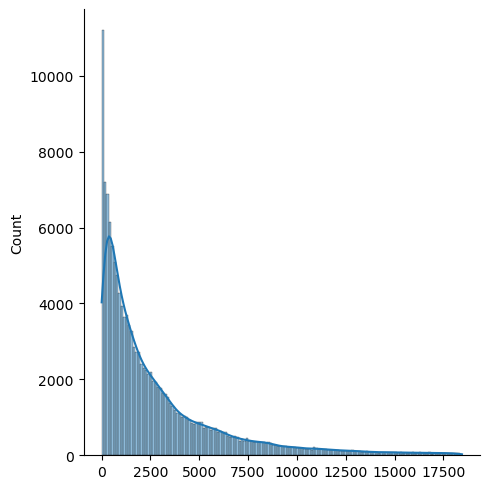

In [342]:
def is_outlier(points, thresh=3.5):
    """
    Returns a boolean array with True if points are outliers and False 
    otherwise.

    Parameters:
    -----------
        points : An numobservations by numdimensions array of observations
        thresh : The modified z-score to use as a threshold. Observations with
            a modified z-score (based on the median absolute deviation) greater
            than this value will be classified as outliers.

    Returns:
    --------
        mask : A numobservations-length boolean array.

    References:
    ----------
        Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality Control:
        Statistical Techniques, Edward F. Mykytka, Ph.D., Editor. 
    """
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

OUTLIER_THRESHOLD = 2.5
filtered = np.array(deltas_fp)
filtered = filtered[~is_outlier(filtered, thresh=OUTLIER_THRESHOLD)]
sns.displot(deltas_fp, kind="kde", bw_adjust=.2)
#sns.displot(filtered, kind="kde", bw_adjust=.05)
sns.displot(filtered, kde=True)
print("Percentage of total FP deltas within filtered", len(filtered) / len(deltas_fp))
print("Percentage of total FP deltas (but removed excessive values) within filtered", len(filtered) / len(deltas_fp[deltas_fp < 10]))

OUTLIER_THRESHOLD = 6
deltas_long_np = np.array(deltas_long, dtype=np.float64)
filtered = np.array(deltas_long_np)
filtered = filtered[~is_outlier(filtered, thresh=OUTLIER_THRESHOLD)]
sns.displot(deltas_long_np, kind="kde", bw_adjust=.2)
#sns.displot(filtered, kind="kde", bw_adjust=.05)
sns.displot(filtered, kde=True)
print("Percentage of total LONG + ZZ deltas within filtered", len(filtered) / len(deltas_long_np))
print("Percentage of total LONG + ZZ deltas (but removed excessive values) within filtered", len(filtered) / len(deltas_long_np[deltas_long_np < 4 * pow(10, 18)]))

In [343]:
for i in range(1):
    idx = random.randint(0, len(deltas_fp))
    print("---")
    print("Delta in FP and LONG:    ", f'{deltas_fp[idx]:.14f}', '        ', deltas_long[idx])
    print("Converting to f32:       ", f'{struct.unpack("!f", struct.pack("!f", deltas_fp[idx]))[0]:.14f}')
    print("Required bits:           ", math.ceil(math.log2(deltas_long[idx] + 1)))
    bin = util.int2ba(deltas_long[idx], length=64)
    print("ZZ-encoded:              ", end=None)
    util.pprint(bin, width=200)

    bin = bitarray()
    print("FP directly to bin:      ", end=None)
    bin.frombytes(struct.pack("!d", deltas_fp[idx]))
    util.pprint(bin, width=200)

    bin = bitarray()
    print("FP32 directly to bin:    ", end=None)
    bin.frombytes(struct.pack("!f", deltas_fp[idx]))
    
    util.pprint(bin, width=200)

---
Delta in FP and LONG:     13.21667760000000          528667104
Converting to f32:        13.21667766571045
Required bits:            29
ZZ-encoded:              
bitarray('00000000 00000000 00000000 00000000 00011111 10000010 11010001 11100000')
FP directly to bin:      
bitarray('01000000 00101010 01101110 11110000 01011101 11001011 10001101 00110010')
FP32 directly to bin:    
bitarray('01000001 01010011 01110111 10000011')


## Entrpoy Encoding Analysis

In [344]:
import warnings
warnings.filterwarnings('ignore')

#Created stats variables for all deltas in general, per defined optimal size and per geometry
glob_delta_freqs = []
opt_size_delta_freqs = defaultdict(list)
geom_delta_freq = defaultdict(list)

In [345]:
#Fill list of previous variables
for idx in tqdm.tqdm(unary_idxs): # List of single idxs
    opt_size, bit_count, deltas = calculate_delta_size(shape(df.iloc[idx]), True)
    for delta in deltas[1]:
        #If coordinate not delta_encoded
        if delta != 0 and math.log2(delta) > opt_size:
            continue
        glob_delta_freqs.append(delta)
        opt_size_delta_freqs[opt_size].append(delta)
        geom_delta_freq[idx].append(delta)

100%|██████████| 10259/10259 [00:02<00:00, 4684.59it/s]


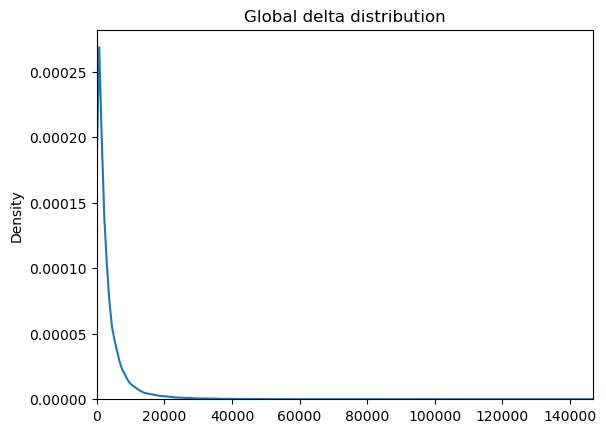

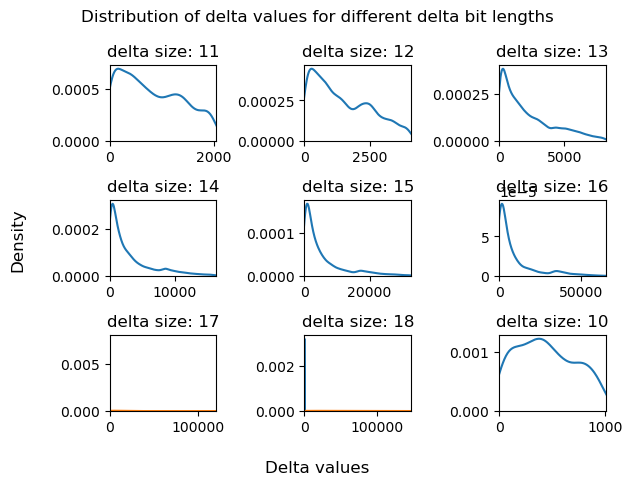

In [346]:
plt.title("Global delta distribution")
ax = sns.kdeplot(glob_delta_freqs)
ax.set_xlim(0, max(glob_delta_freqs))
plt.show()

HEIGHT, WIDTH = 3,3
fig, axes = plt.subplots(WIDTH, HEIGHT)

for idx, os in enumerate(sorted(opt_size_delta_freqs.keys())):
    axes[idx // WIDTH - 1,idx % HEIGHT].set_title("delta size: {}".format(os))
    ax = sns.kdeplot(opt_size_delta_freqs[os], ax=axes[idx // WIDTH - 1,idx % HEIGHT])
    axes[idx // WIDTH - 1,idx % HEIGHT].set_xlim(0, max(opt_size_delta_freqs[os]))
    axes[idx // WIDTH - 1,idx % HEIGHT].set(ylabel=None)

fig.supylabel('Density')
fig.supxlabel('Delta values')
fig.suptitle('Distribution of delta values for different delta bit lengths')
plt.tight_layout()

plt.show()

#### Delta prefix analysis

In [347]:
PREFIX_LENGTH = 6
opt_prefix_freqs = None
glob_prefix_freqs = None

def get_entropy_codes(frequency_list):
    codes = util.canonical_huffman(frequency_list)
    return codes[0]

def calculate_prefix_counts(prefix_len):
    cnt_prefix_opt = defaultdict(dict)
    cnt_prefix_global = defaultdict(int)
    for opt_size in tqdm.tqdm(opt_size_delta_freqs):
        deltas = opt_size_delta_freqs[opt_size]
        for d in deltas:
            bits = uint_to_ba(d,opt_size)
            prefix_bits = bits[:prefix_len].to01()
            cnt_prefix_global[prefix_bits] += 1
            if prefix_bits in cnt_prefix_opt[opt_size]:
                cnt_prefix_opt[opt_size][prefix_bits] += 1
            else:
                cnt_prefix_opt[opt_size][prefix_bits] = 1
    return cnt_prefix_opt, cnt_prefix_global

opt_prefix_freqs, glob_prefix_freqs = calculate_prefix_counts(PREFIX_LENGTH)


100%|██████████| 11/11 [00:00<00:00, 34.36it/s]


In [348]:
global_codes =  get_entropy_codes(glob_prefix_freqs)
opt_size_codes = {opt_size: get_entropy_codes(opt_size_prefix_freqs[opt_size]) for opt_size in opt_size_prefix_freqs}


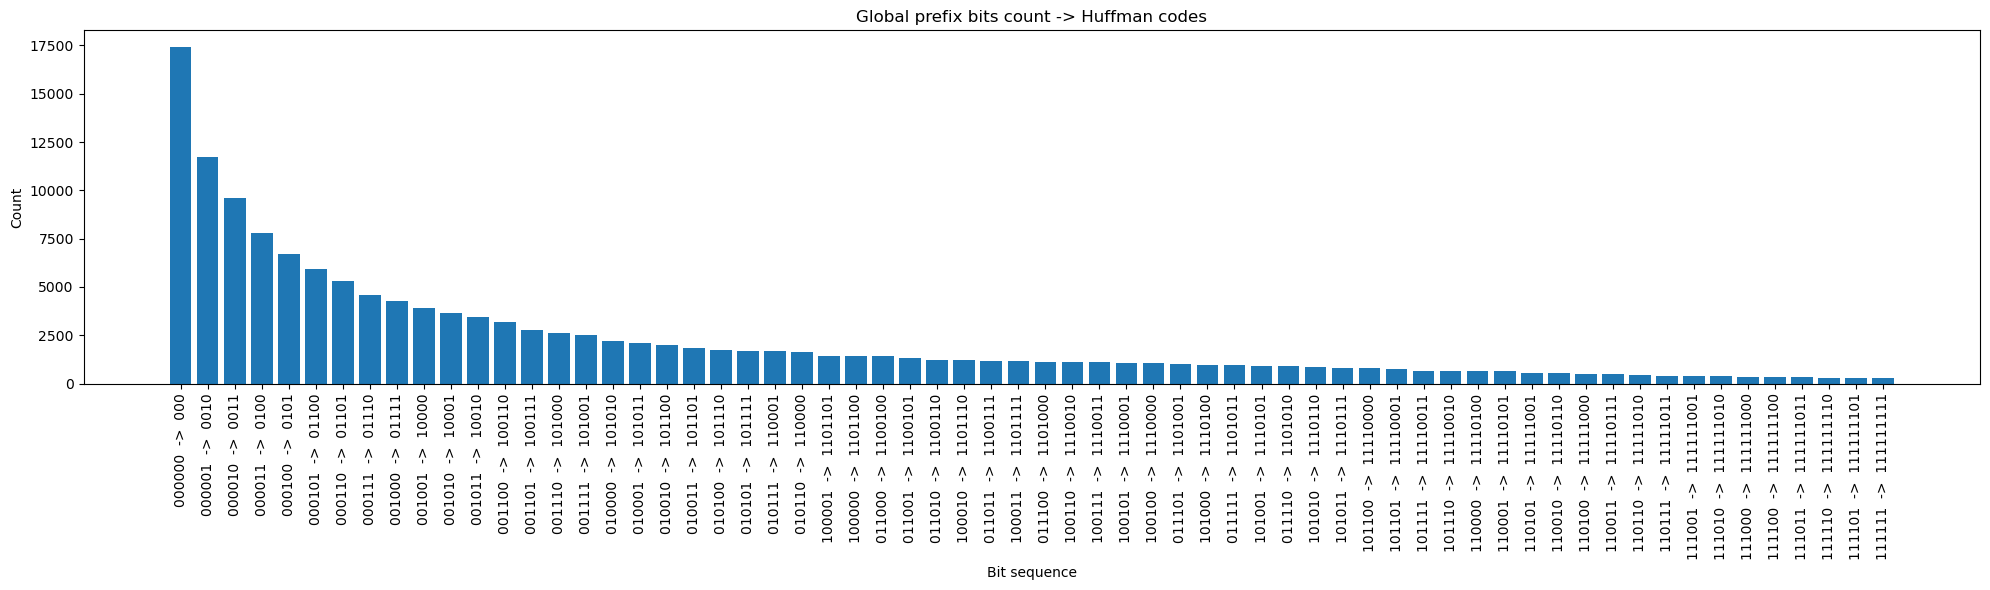

11it [00:00, 15.34it/s]


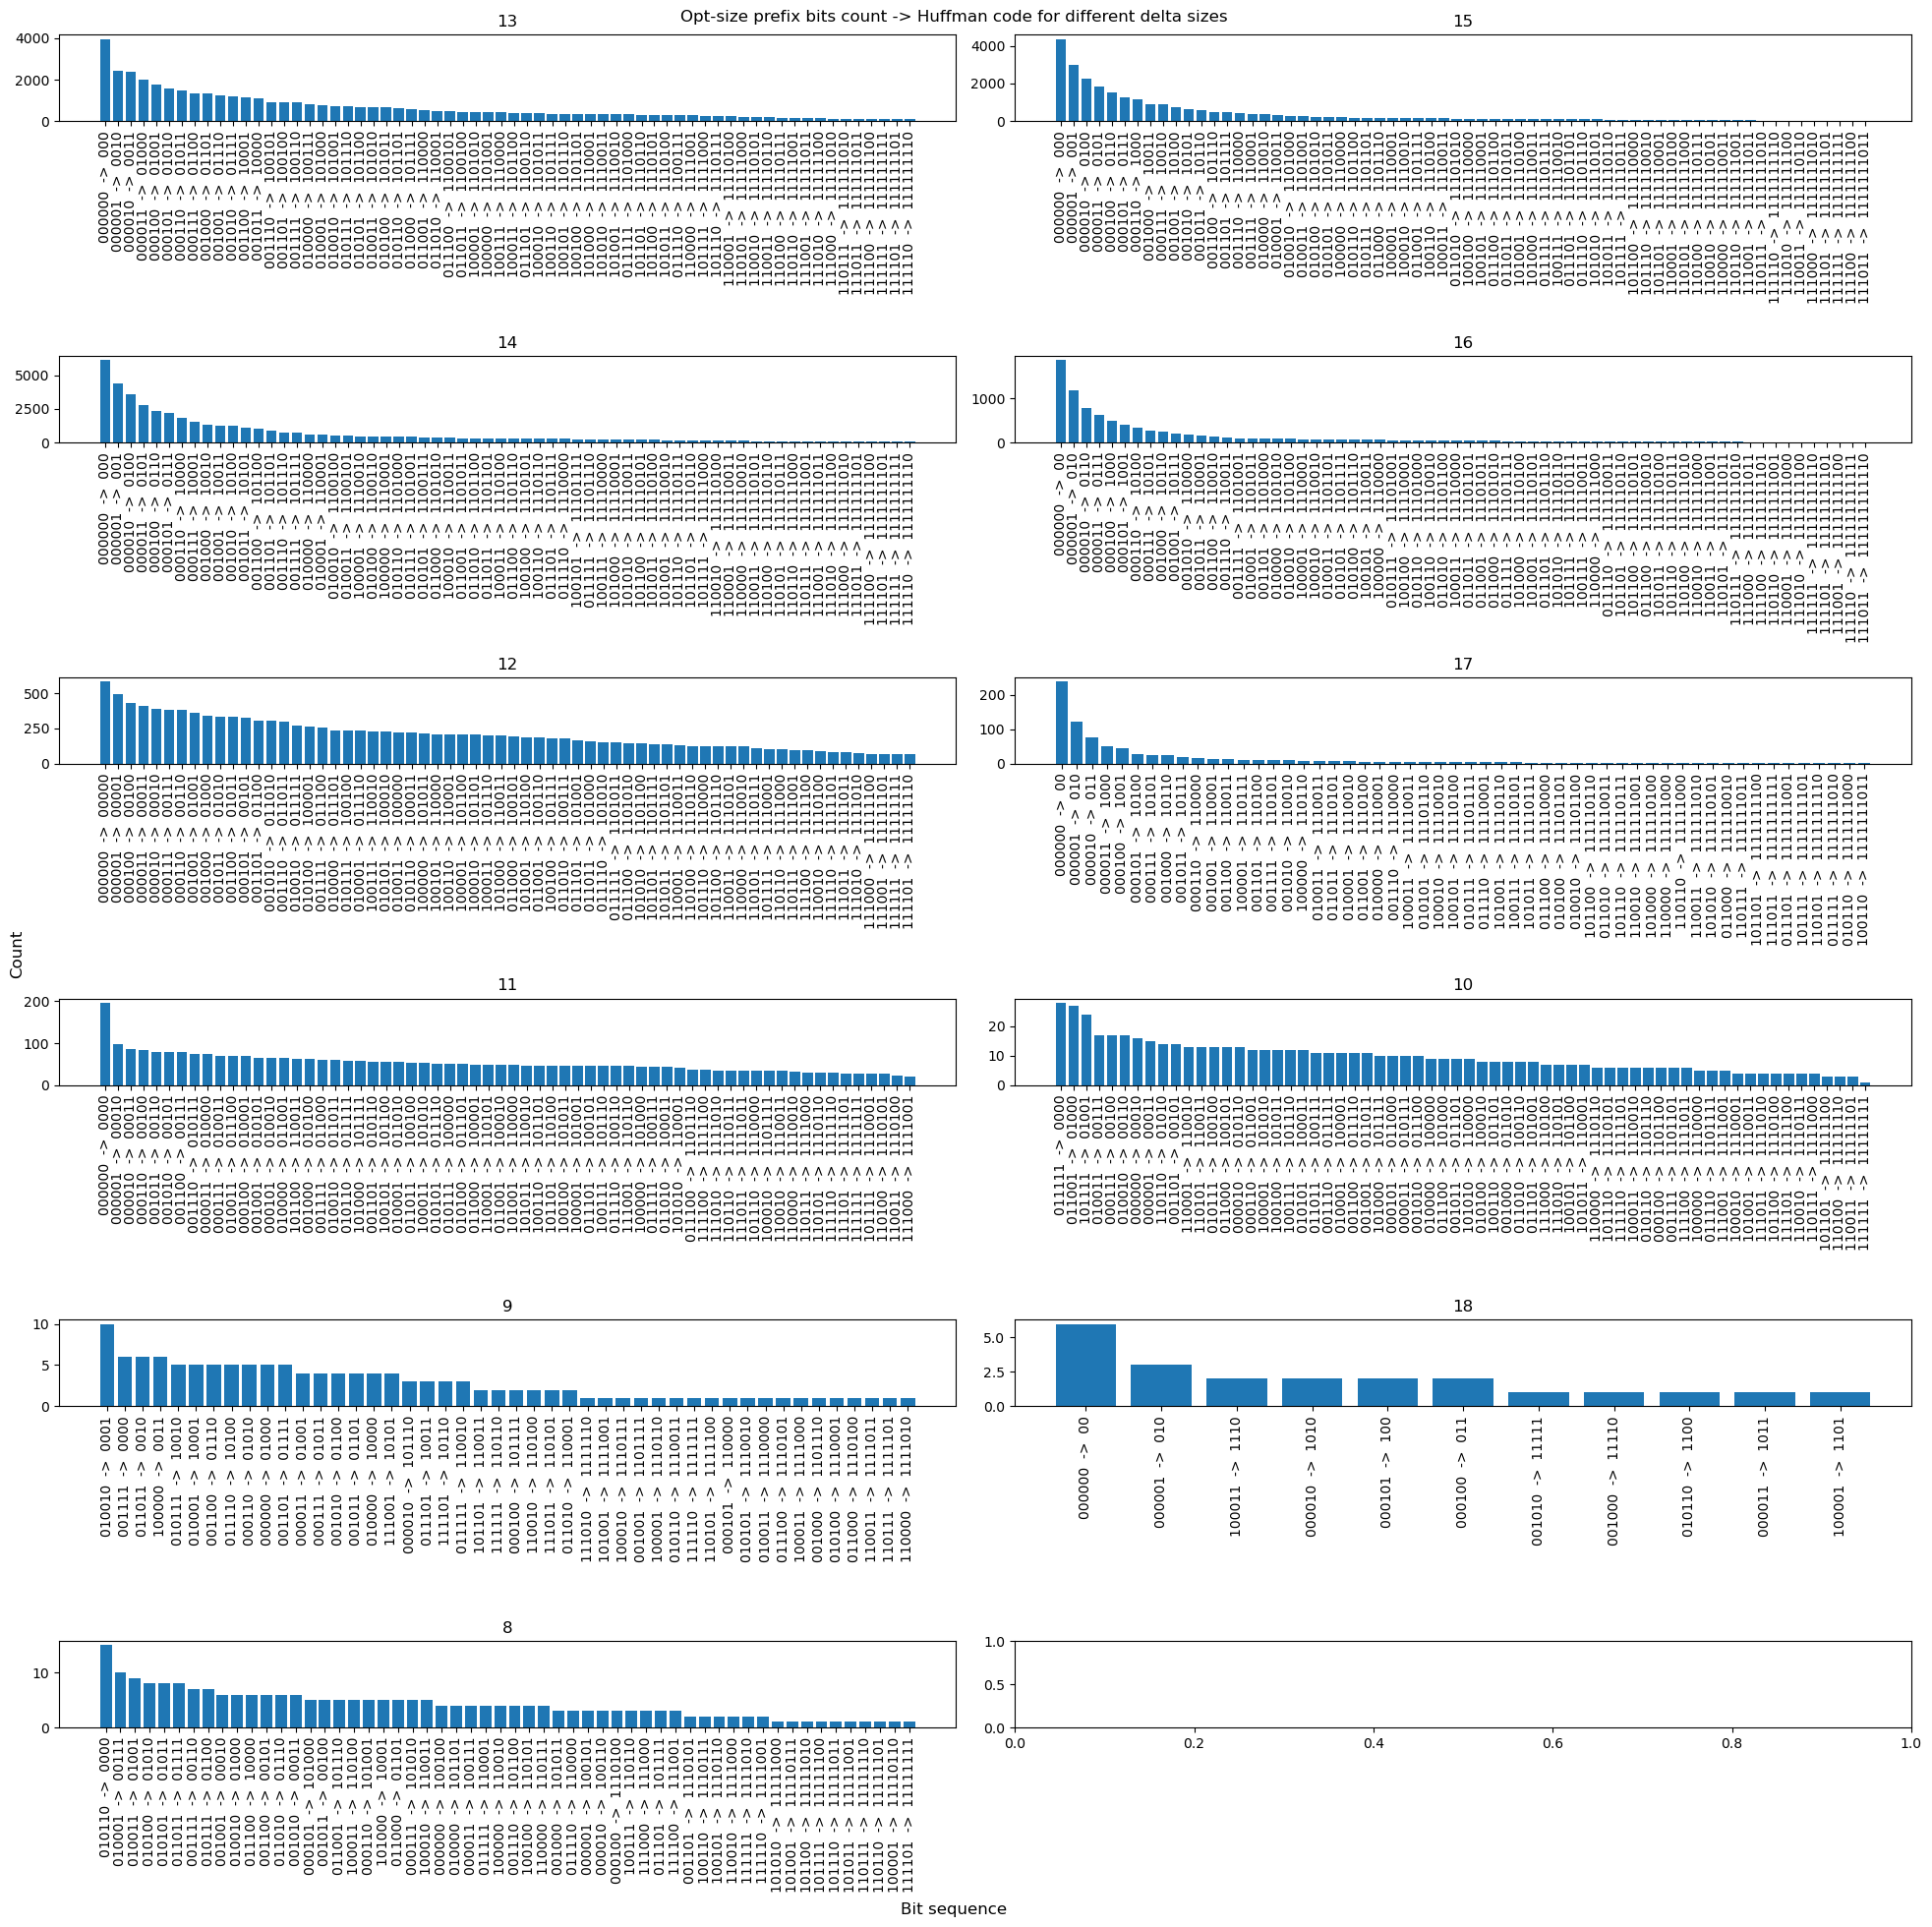

In [349]:

def plot_prefix_frequency(opt_size_freq, glob_freq):
    #Plot global data
    dictionary = dict(sorted(glob_freq.items(), key=lambda x:-x[1]))

    plt.figure(figsize=(20,6))
    plt.bar(dictionary.keys(), dictionary.values())

    plt.title("Global prefix bits count -> Huffman codes")
    plt.xlabel("Bit sequence")
    plt.ylabel("Count")
    plt.xticks(rotation=90)
    locs, _ = plt.xticks()  # Get the current locations and labels.
    plt.xticks(locs, ["{}  ->  {}".format(key,global_codes[key].to01()) for key in dictionary.keys()], rotation = 90)
    plt.tight_layout()
    plt.show()

    #Plot delta size specific data
    fig, axs = plt.subplots(len(opt_size_freq) // 2 + 1, 2, sharex=False, sharey=False)

    for idx, opt_delta in tqdm.tqdm(enumerate(opt_size_freq)):
        dictionary = dict(sorted(opt_size_freq[opt_delta].items(), key=lambda x:-x[1]))
        codes = opt_size_codes[opt_delta]

        axs[idx // 2,idx % 2].bar(dictionary.keys(), dictionary.values())
        axs[idx // 2,idx % 2].set_title(opt_delta)        
        axs[idx // 2,idx % 2].set_xticklabels(["{}  ->  {}".format(key,codes[key].to01()) for key in dictionary.keys()], rotation = 90)
    
    fig.suptitle("Opt-size prefix bits count -> Huffman code for different delta sizes")
    fig.supylabel('Count')
    fig.supxlabel('Bit sequence')
    fig.tight_layout()
    fig.set_figheight(20)
    fig.set_figwidth(20)

    plt.tight_layout()
    plt.show()

plot_prefix_frequency(opt_size_prefix_freqs,glob_prefix_freqs)


In [350]:

def inner_prefix_diff_calc(codes, bit_freqs):
    diff_count = defaultdict(int)
    pos_neg_count = {'-':0, '+':0} 
    for bits_to_codes in codes:
        diff = len(codes[bits_to_codes].to01()) - len(bits_to_codes)
        bits_to_code_cnt = bit_freqs[bits_to_codes]
        bits_diff = bits_to_code_cnt * abs(diff)

        if diff in diff_count:
            diff_count[diff] += bits_to_code_cnt
        else:
            diff_count[diff] = bits_to_code_cnt
        if diff < 0:
            pos_neg_count["-"] += bits_diff
        if diff > 0:
            pos_neg_count["+"] += bits_diff 
            
    return diff_count, pos_neg_count

def opt_size_prefix_diff_calc(diff_count, pos_neg_count):
    diff_count = defaultdict(dict)
    pos_neg_count = defaultdict(dict)
    for opt_size in dict(sorted(opt_size_prefix_freqs.items(), key=lambda x:x[0])):
        diff_count[opt_size], pos_neg_count[opt_size] = inner_prefix_diff_calc(opt_size_codes[opt_size], opt_size_prefix_freqs[opt_size])            
    return diff_count, pos_neg_count

def set_subplt_fig_attributes(fig, title, y_label, x_label, x_size, y_size):
    fig.suptitle(title)
    fig.supylabel(y_label)
    fig.supxlabel(x_label)
    fig.tight_layout()
    fig.set_figheight(y_size)
    fig.set_figwidth(x_size)
    plt.tight_layout()




11it [00:00, 274.68it/s]


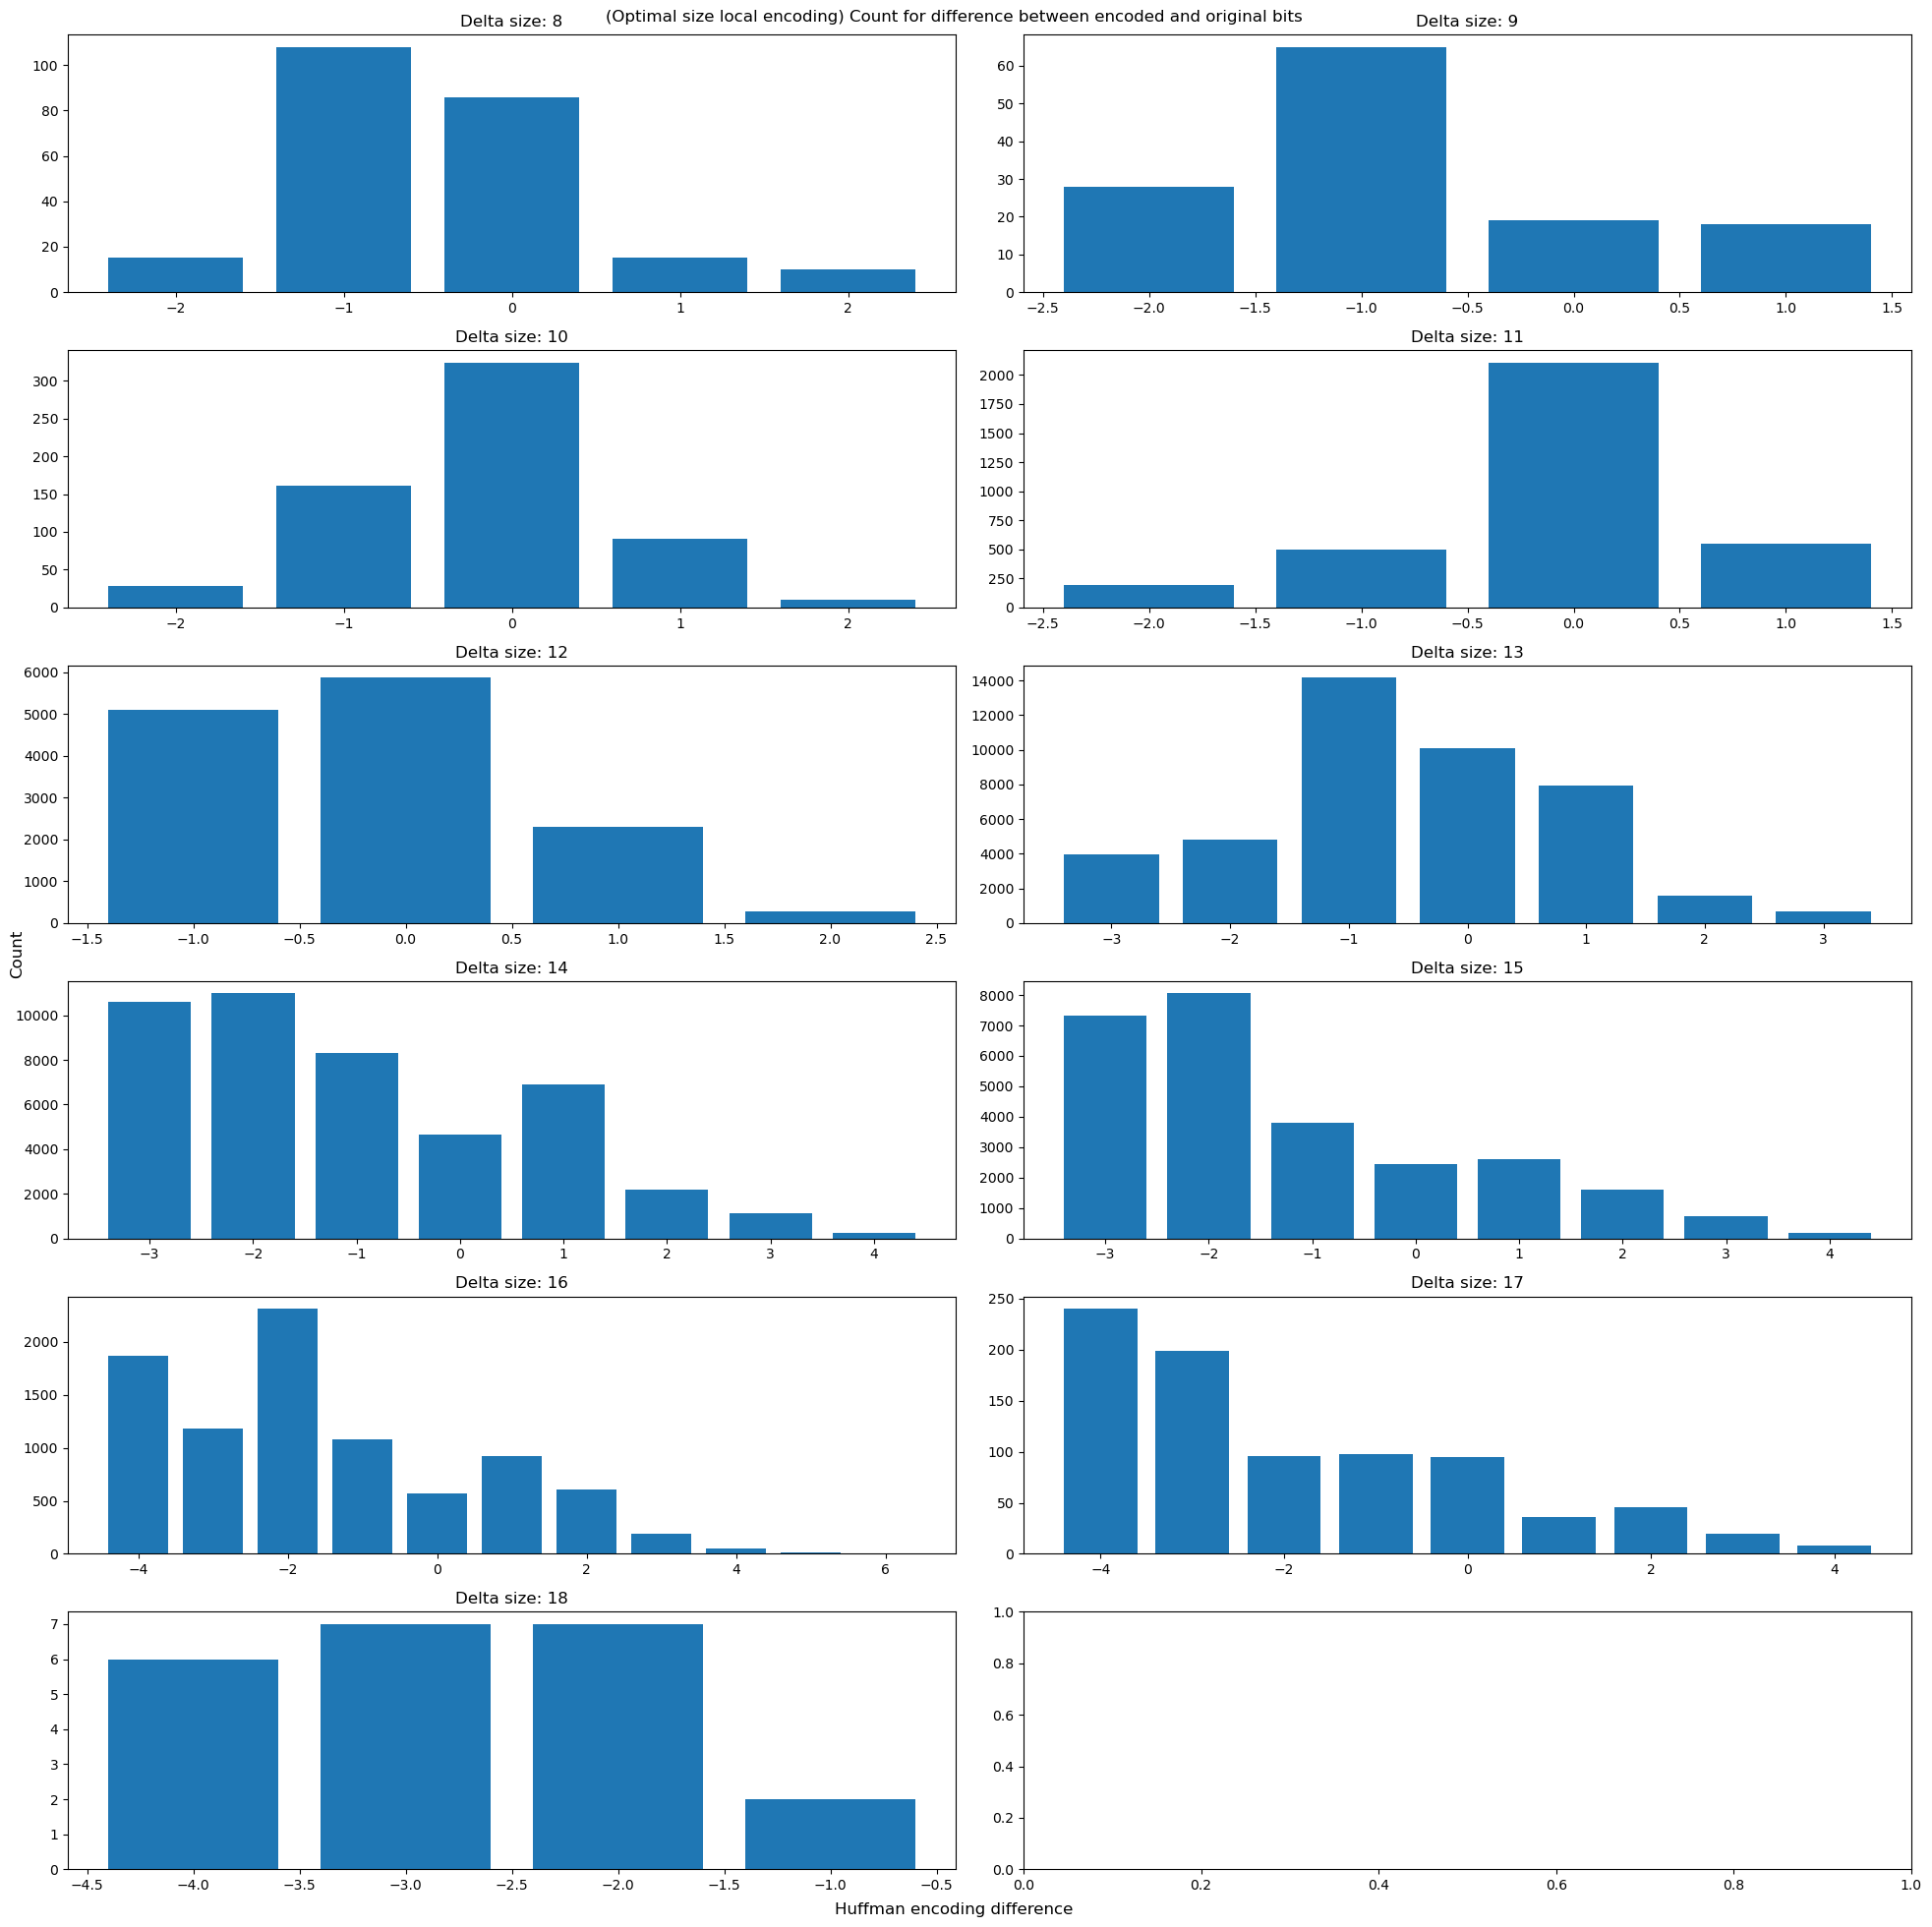

11it [00:00, 417.14it/s]


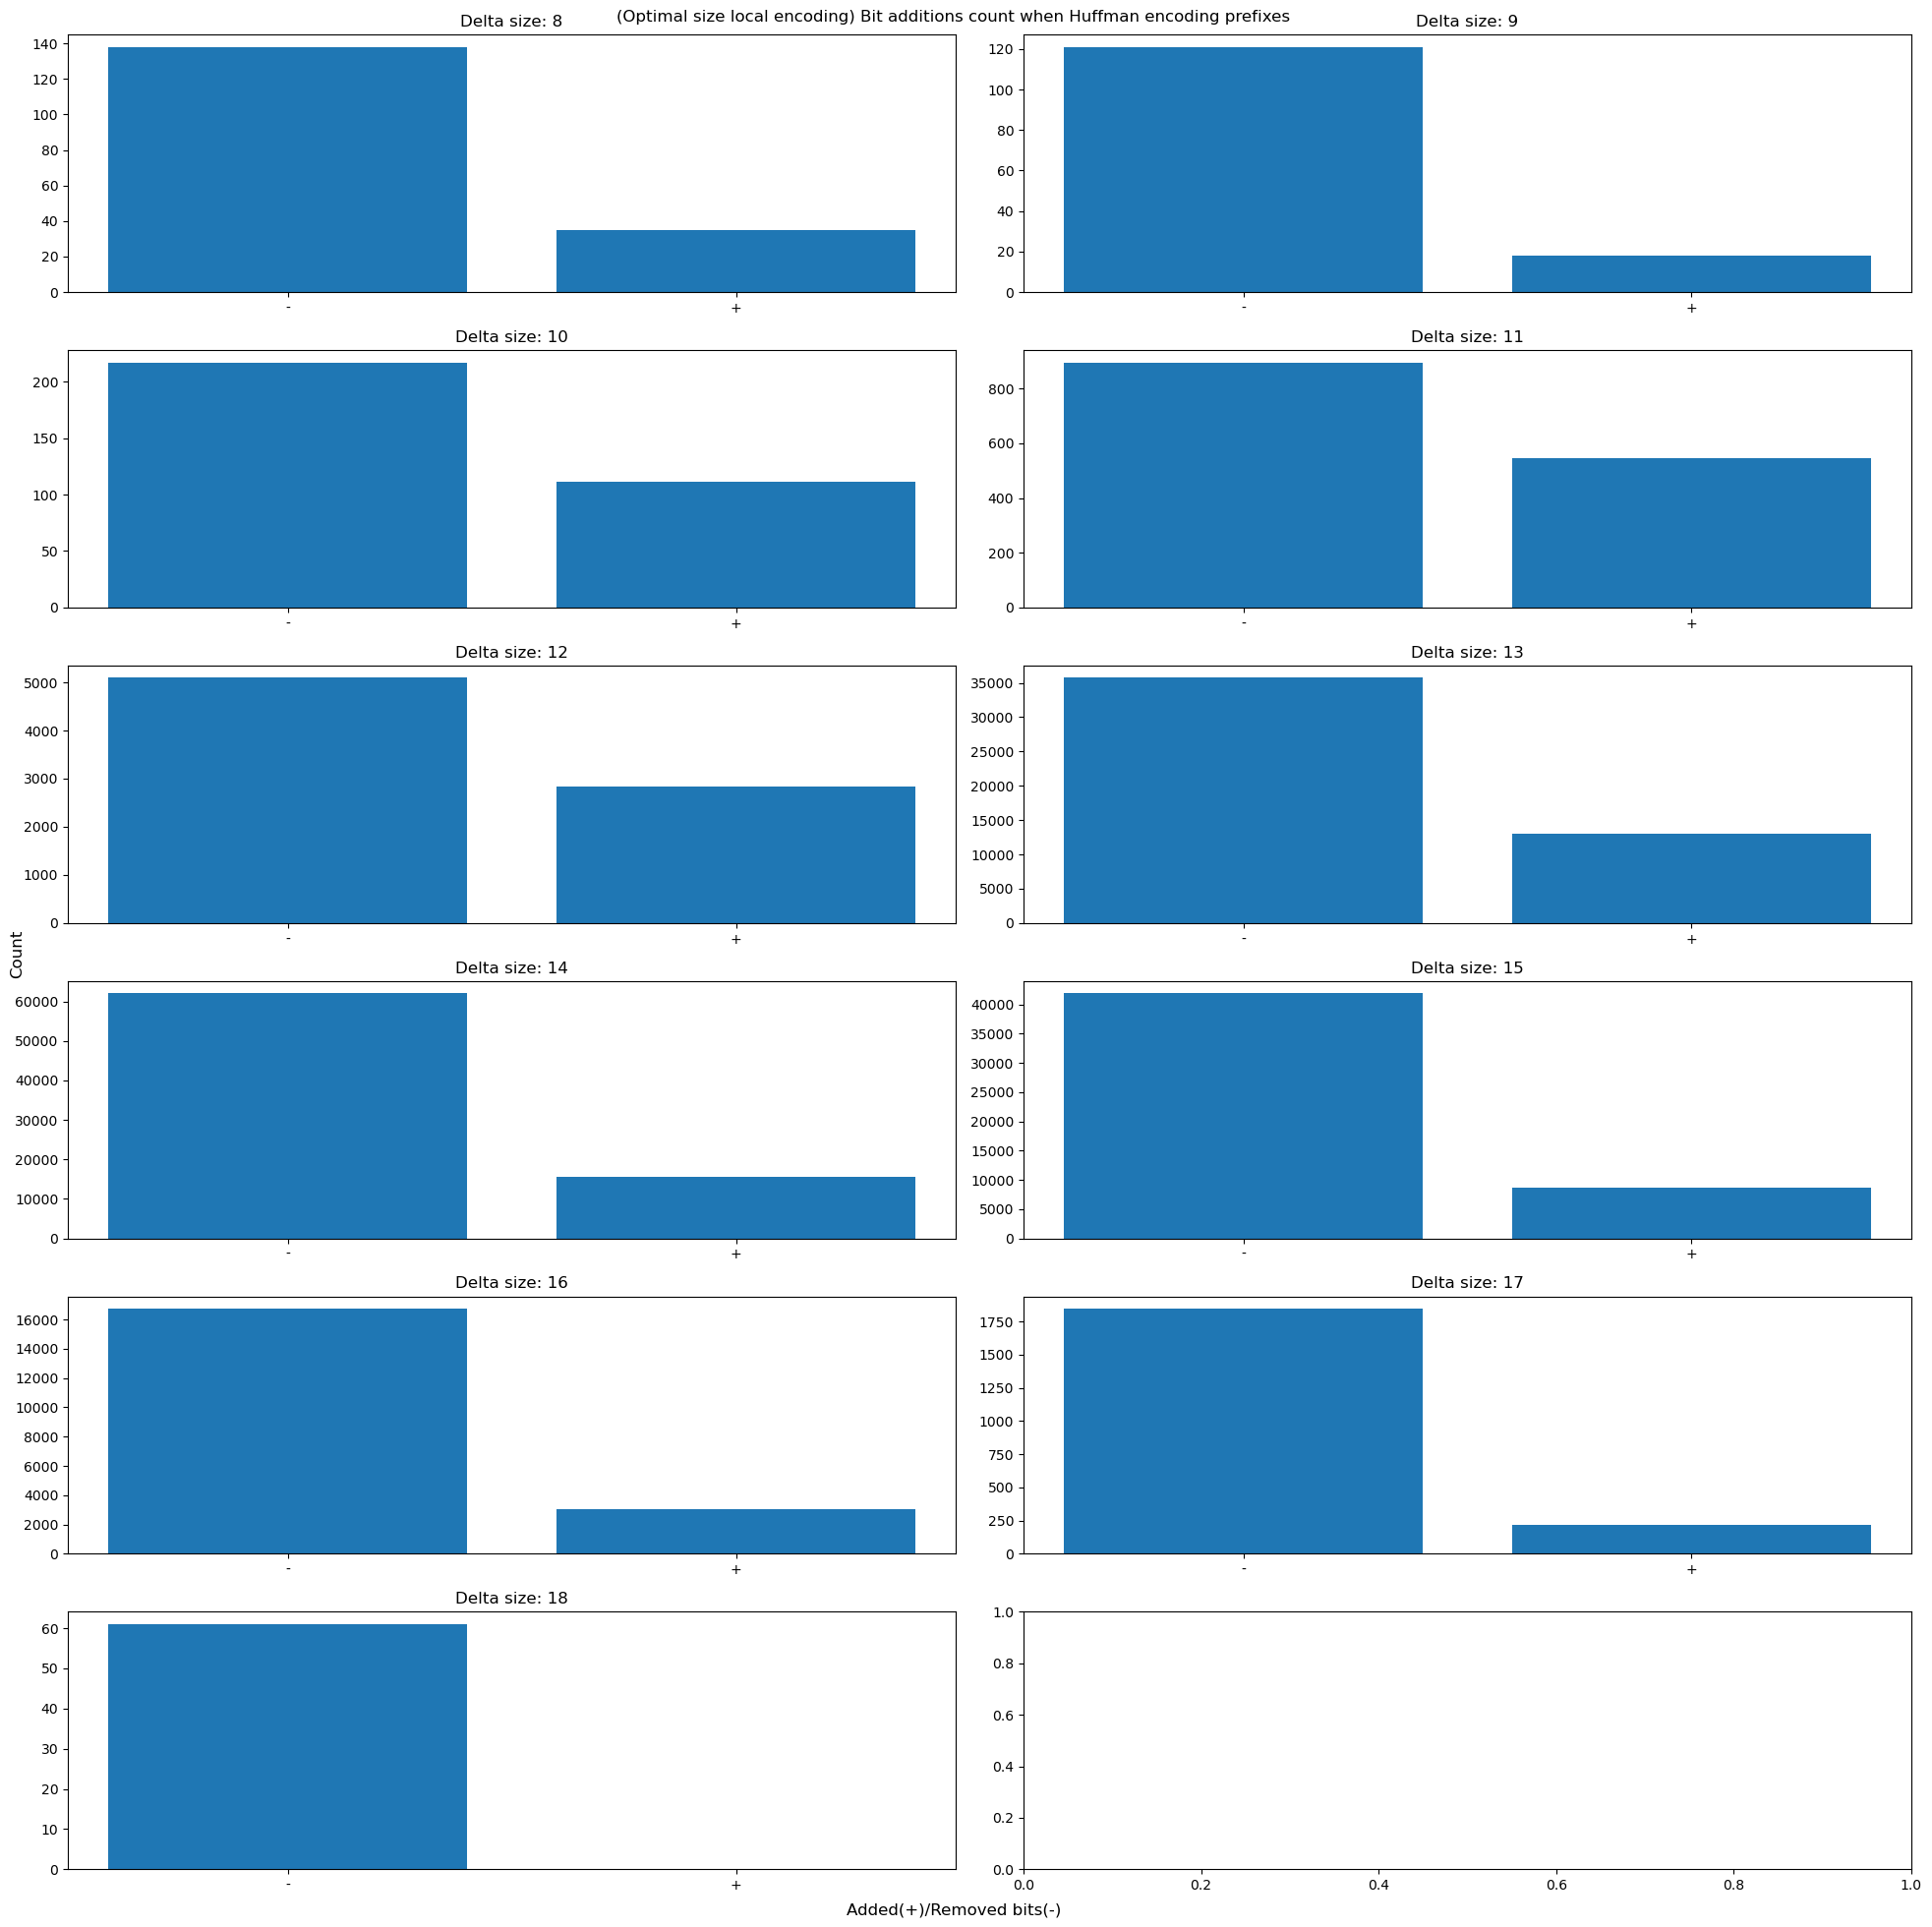

In [351]:

opt_size_prefix_diff_calc(opt_size_prefix_diff_count, opt_size_prefix_pos_neg_count)
fig, axs = plt.subplots(len(opt_size_prefix_diff_count) // 2 + 1, 2, sharex=False, sharey=False)

for idx, opt_delta in tqdm.tqdm(enumerate(opt_size_prefix_diff_count)):
    dictionary = dict(sorted(opt_size_prefix_diff_count[opt_delta].items(), key=lambda x:-x[1]))
    axs[idx // 2,idx % 2].bar(dictionary.keys(), dictionary.values())
    axs[idx // 2,idx % 2].set_title("Delta size: {}".format(opt_delta)) 
set_subplt_fig_attributes(fig,"(Optimal size local encoding) Count for difference between encoded and original bits", 'Count', 'Huffman encoding difference', 20, 20)       

plt.show()

fig, axs = plt.subplots(len(opt_size_prefix_pos_neg_count) // 2 + 1, 2, sharex=False, sharey=False)

for idx, opt_delta in tqdm.tqdm(enumerate(opt_size_prefix_pos_neg_count)):
    dictionary = dict(sorted(opt_size_prefix_pos_neg_count[opt_delta].items(), key=lambda x:-x[1]))
    axs[idx // 2,idx % 2].bar(dictionary.keys(), dictionary.values())
    axs[idx // 2,idx % 2].set_title("Delta size: {}".format(opt_delta))        
set_subplt_fig_attributes(fig,"(Optimal size local encoding) Bit additions count when Huffman encoding prefixes", 'Count', 'Added(+)/Removed bits(-)', 20, 20)       



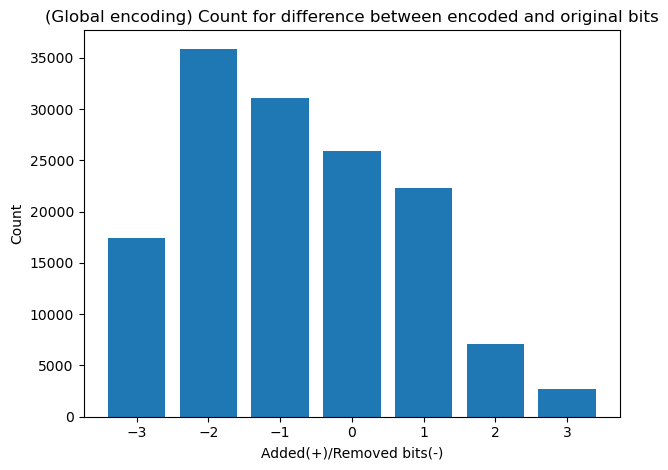

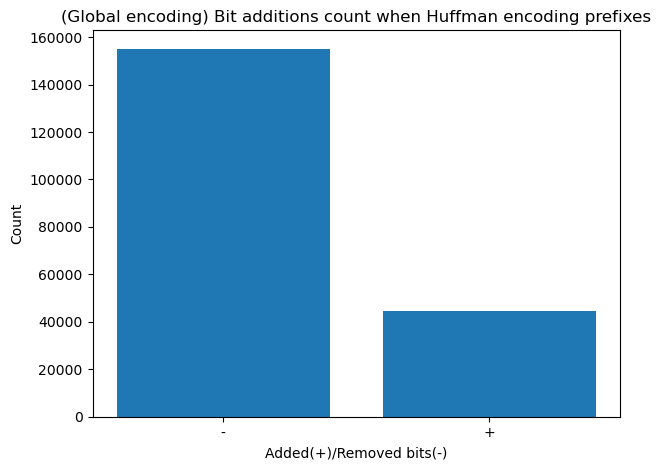

In [355]:


global_prefix_diff_count, global_prefix_pos_neg_count = inner_prefix_diff_calc(global_codes, glob_prefix_freqs)


def set_fig_attributes(title, y_label, x_label):
    plt.title(title)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.tight_layout()

plt.bar(global_prefix_diff_count.keys(),global_prefix_diff_count.values())
plt.ylabel
set_fig_attributes("(Global encoding) Count for difference between encoded and original bits", 'Count', 'Added(+)/Removed bits(-)')   
plt.show()

plt.bar(global_prefix_pos_neg_count.keys(),global_prefix_pos_neg_count.values())
set_fig_attributes("(Global encoding) Bit additions count when Huffman encoding prefixes", 'Count', 'Added(+)/Removed bits(-)')     
plt.show()


In [ ]:

#Prints stats for geometries if they use huffman codes based on frequencies over all geometries WITH the same delta size when compressed
print("\nUsing (global + optimal size) specific entropy codes")
total_original, total_entropy = 0, 0
for opt_size in dict(sorted(bit_counts_per_opt_size.items(), key=lambda x:x[0])):
    dictionary = bit_counts_per_opt_size[opt_size]
    original_prefix_size, entropy_encoded_size = get_prefix_decrease(get_entropy_codes(dictionary), dictionary, "Optimal delta length   {}".format(opt_size), opt_size)
    total_original += original_prefix_size
    total_entropy  += entropy_encoded_size
print("=\nTotal (GLOBAL + Optimal Size)", "\toriginal size  = ",  total_original, " bits\t\tentropy encoded size  = ", total_entropy, "bits\t%-diff (Prefix)  = ", total_entropy/total_original)


#Prints stats for geometries if they use huffman codes based on frequencies over all geometries
print("_______________________________________________________________________________________________________________________________________________________")

print("\nUsing global specific entropy codes\n")
for opt_size in dict(sorted(bit_counts_per_opt_size.items(), key=lambda x:x[0])):
    dictionary = bit_counts_per_opt_size[opt_size]
    original_prefix_size, entropy_encoded_size = get_prefix_decrease(get_entropy_codes(global_bit_counts), dictionary, "Optimal delta length   {}".format(opt_size), opt_size)
    

global_original_prefix_size, global_entropy_encoded_size = get_prefix_decrease(get_entropy_codes(global_bit_counts), global_bit_counts, "=\nTotal (GLOBAL)\t\t")


Using (global + optimal size) specific entropy codes
Optimal delta length   8	original size  = 1404 bits	entropy encoded size  = 1301 bits 	%-diff (Prefix)  = 0.9266381766381766 	%-diff (Delta)  =  0.9685592185592186


ValueError: too many values to unpack (expected 2)

In [ ]:
for opt_size in bit_counts_per_opt_size.items():
    dictionary = bit_counts_per_opt_size[opt_size]
    _, _, sizes_dict = get_prefix_decrease(get_entropy_codes(dictionary), dictionary, "Optimal delta length   {}".format(opt_size), opt_size)
    plt.bar(sizes_dict.keys(),)
    